#Запуск алгоритма

In [4]:
#@title Установка пакетов
!pip  install langchain==0.0.335 openai==1.2.3 tiktoken==0.5.1 pydantic==1.10.8 faiss-cpu==1.7.4 nltk oauth2client >/dev/null



In [5]:
#@title Импорт библиотек

import os
import getpass
import requests

from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter
from langchain.text_splitter import MarkdownHeaderTextSplitter, RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.document_loaders import TextLoader
import openai
from openai import OpenAI
import tiktoken
import re
import requests
from langchain.docstore.document import Document
import matplotlib.pyplot as plt


In [6]:
#@title Определим функции

def load_text_from_github(kdb_link):
## правильная ссылка: https://github.com/terrainternship/GPT_LaserLove/raw/main/instruction_1.txt
## неправильная ссылка:  https://github.com/terrainternship/GPT_LaserLove/blob/main/instruction_1.txt
  response = requests.get(kdb_link)
  txt = response.text
  return txt

def load_googledoc_by_url(doc_url) -> str: # Функция load_googledoc_by_url предназначена для загрузки текста из гуглдока, по ссылке (doc_url)
  # Extract the document ID from the URL
  match_ = re.search('/document/d/([a-zA-Z0-9-_]+)', doc_url)
  if match_ is None:
    raise ValueError('Invalid Google Docs URL')
  doc_id = match_.group(1)

  # Download the document as plain text
  response = requests.get(f'https://docs.google.com/document/d/{doc_id}/export?format=txt')
  response.raise_for_status()
  return response.text

def load_document_text(file_path) -> str:   # Функция load_document_text предназначена для загрузки текста из файла, расположенного по указанному пути (file_path)
#    with open(file_path, 'r', encoding='windows-1251') as file:
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    text_encoded = text.encode('utf-8')
    text = text_encoded.decode('utf-8')
    return text


def num_tokens_from_string(string: str, encoding_name: str) -> int:
      """Возвращает количество токенов в строке"""
      encoding = tiktoken.get_encoding(encoding_name)
      num_tokens = len(encoding.encode(string))
      return num_tokens

def split_text(text, max_count, chunk_overlap, verbose=0, double_split=1):
    # Функция для подсчета количества токенов в фрагменте
    def num_tokens(fragment):
        return num_tokens_from_string(fragment, "cl100k_base")

    headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2"),
    ("###", "Header 3"),
                          ]
    markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
    fragments = markdown_splitter.split_text(text)

    # Создание объекта разделителя текста
    splitter = RecursiveCharacterTextSplitter(chunk_size=max_count, chunk_overlap=chunk_overlap, length_function=num_tokens)

    # Список для хранения фрагментов текста
    source_chunks = []

    # Обработка каждого фрагмента текста
    for fragment in fragments:

        if verbose:
            # Вывод количества слов/токенов в фрагменте, если включен режим verbose
            count = num_tokens(fragment.page_content)
            print(f"Tokens in text fragment = {count}\n{'-' * 5}\n{fragment.page_content}\n{'=' * 20}")
        if double_split:
          # Разбиение фрагмента текста на части заданной длины с помощью разделителя
          # и добавление каждой части в список source_chunks  и передача в чанк метадата из маркдауновскго сплиттера
          source_chunks.extend(Document(page_content=chunk, metadata=fragment.metadata) for chunk in splitter.split_text(fragment.page_content))
        else:
          source_chunks = fragments

    # Возвращение списка фрагментов текста
    return source_chunks

def create_search_index(data, chunk_size, chunk_overlap, verbo):
    source_chunks = []
    source_chunks = split_text(text=data, max_count=chunk_size, chunk_overlap=chunk_overlap, verbose=verbo)
    return FAISS.from_documents(source_chunks, OpenAIEmbeddings())

def num_tokens_from_messages(messages, model="gpt-3.5-turbo-0301"):
    """Returns the number of tokens used by a list of messages."""
    try:
        encoding = tiktoken.encoding_for_model(model)
    except KeyError:
        encoding = tiktoken.get_encoding("cl100k_base")
    if model == "gpt-3.5-turbo-0301":  # note: future models may deviate from this
        num_tokens = 0
        for message in messages:
            num_tokens += 4  # every message follows <im_start>{role/name}\n{content}<im_end>\n
            for key, value in message.items():
                num_tokens += len(encoding.encode(value))
                if key == "name":  # if there's a name, the role is omitted
                    num_tokens += -1  # role is always required and always 1 token
        num_tokens += 2  # every reply is primed with <im_start> assistant
        return num_tokens
    else:
        raise NotImplementedError(f"""num_tokens_from_messages() is not presently implemented for model {model}.""")


def answer_user_question(system_doc_text, knowledge_base_url, topic, instructions, temperature, verbose, k, chunk_size, chunk_overlap, model):
    knowledge_base_text = load_googledoc_by_url(knowledge_base_url)
    knowledge_base_index = create_search_index(knowledge_base_text, chunk_size, chunk_overlap, verbose)
    return answer_index(system_doc_text, topic, instructions, knowledge_base_index, temperature, verbose, k, model)


def answer_index(system, topic, instructions, search_index, temp, verbose, k, model):
    docs = search_index.similarity_search_with_score(topic, k=k)
    message_content = '\n '.join([f'Отрывок текста №{i+1}\n{doc[0].page_content}' for i, doc in enumerate(docs)])
    messages = [{"role": "system", "content": system}, {"role": "user", "content": f"{instructions}\n\nТексты для анализа:\n{message_content}"}]

    completion = openai.chat.completions.create(model=model, messages=messages, temperature=temp)
    return completion.choices[0].message.content



#Получение ключа API от пользователя и установка его как переменной окружения

In [7]:
#@title Получение ключа API от пользователя и установка его как переменной окружения
openai_key = getpass.getpass("OpenAI API Key:")
os.environ["OPENAI_API_KEY"] = openai_key
openai.api_key = openai_key

OpenAI API Key:··········


#Обработка БЗ

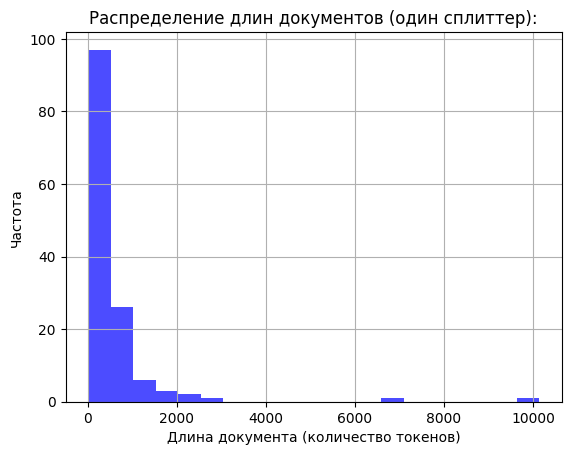

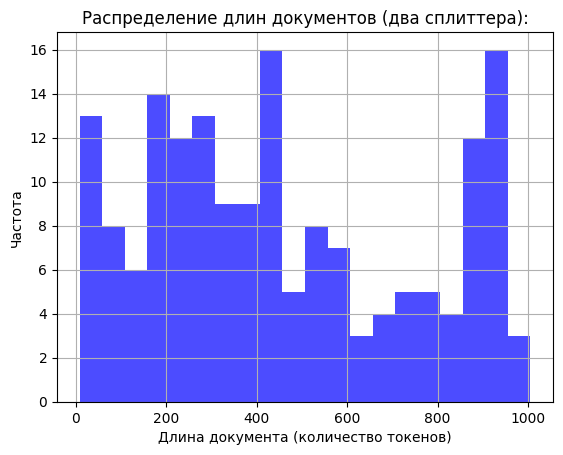

In [8]:
#@title Обрабатываем БЗ
model = "gpt-3.5-turbo-1106" #@param ["gpt-3.5-turbo", "gpt-3.5-turbo-16k", "gpt-3.5-turbo-1106"]
kb_git_link = "https://github.com/terrainternship/GPT_LaserLove/blob/main/knowledge.md?raw=true" #@param {type:"string"}
chunk_size = 1000 #@param {type: "slider", min: 200, max: 1024, step:8}
chunk_overlap = 0 #@param {type: "slider", min: 0, max: 256, step:8}

text = load_text_from_github(kb_git_link)
chunks = split_text(text, chunk_size, chunk_overlap, verbose=0, double_split=0)

# Построим гистограмму
document_lengths = [len(doc.page_content)/2.23 for doc in chunks]
plt.hist(document_lengths, bins=20, color='blue', alpha=0.7)
plt.title('Распределение длин документов (один сплиттер):')
plt.xlabel('Длина документа (количество токенов)')
plt.ylabel('Частота')
plt.grid(True)
plt.show()


double_chunks = split_text(text, chunk_size, chunk_overlap, verbose=0, double_split=1)
# Построим гистограмму
document_lengths = [len(doc.page_content)/2.23 for doc in double_chunks]
plt.hist(document_lengths, bins=20, color='blue', alpha=0.7)
plt.title('Распределение длин документов (два сплиттера):')
plt.xlabel('Длина документа (количество токенов)')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

In [14]:
# Предположим, у вас есть список документов
список_документов = chunks

# Фильтруем только те документы, где длина page_content > chunk_size
отфильтрованный_список = [документ for документ in список_документов if len(документ.page_content)/2.23 > chunk_size]

# Сортируем отфильтрованный список по убыванию длины page_content
отсортированный_список = sorted(отфильтрованный_список, key=lambda x: len(x.page_content)/2.23, reverse=True)

# Выводим результат
for документ in отсортированный_список:
    print(f'Размер чанка {round(len(документ.page_content)/2.23)} токенов: метаданные {документ.metadata}')


Размер чанка 10135 токенов: метаданные {'Header 1': 'Основы лазерной эпиляции.', 'Header 2': 'Типичные вопросы клиентов и ответы на них.'}
Размер чанка 6651 токенов: метаданные {'Header 1': 'Основы ЛПГ. Оборудование Pascal.', 'Header 2': 'Типичные вопросы клиентов и ответы на них.'}
Размер чанка 2754 токенов: метаданные {'Header 1': 'Процедура лазерной эпиляции.', 'Header 2': 'Показания и противопоказания.', 'Header 3': 'Список абсолютных противопоказаний к проведению лазерной эпиляции.'}
Размер чанка 2245 токенов: метаданные {'Header 1': 'Процедура ЛПГ.', 'Header 2': 'Противопоказания общие и локальные.'}
Размер чанка 2209 токенов: метаданные {'Header 1': 'Основы лазерной эпиляции.', 'Header 2': 'Мифы и заблуждения о лазерной эпиляции.'}
Размер чанка 1965 токенов: метаданные {'Header 1': 'Основы ЛПГ. Оборудование Pascal.', 'Header 2': 'Эндодермальный массаж. Теория.', 'Header 3': 'Жировая клетка.'}
Размер чанка 1796 токенов: метаданные {'Header 1': 'Основы ЛПГ. Оборудование Pascal.', 